In [1]:
dados_f1 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F1.csv'
dados_f2 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F2.csv'
dados_f3 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F3.csv'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Fazenda 1

![Alt text: Imagem de uma fazenda com plantações de uvas](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%201.png?raw=true)

In [3]:
df_f1 = pd.read_csv(dados_f1)
df_f1

,DATA,TEMP
0,1963-05-01,23.11
1,1963-06-01,24.20
2,1963-07-01,25.37
3,1963-08-01,23.86
4,1963-09-01,23.03
...,...,...
727,2023-12-01,19.49
728,2024-01-01,19.28
729,2024-02-01,19.73
730,2024-03-01,20.44


In [4]:
df_f1['DATA'] = pd.to_datetime(df_f1['DATA'], format='%Y-%m-%d')
df_f1.set_index(['DATA'], inplace=True, drop=True)
df_f1

,TEMP
DATA,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2023-12-01,19.49
2024-01-01,19.28
2024-02-01,19.73


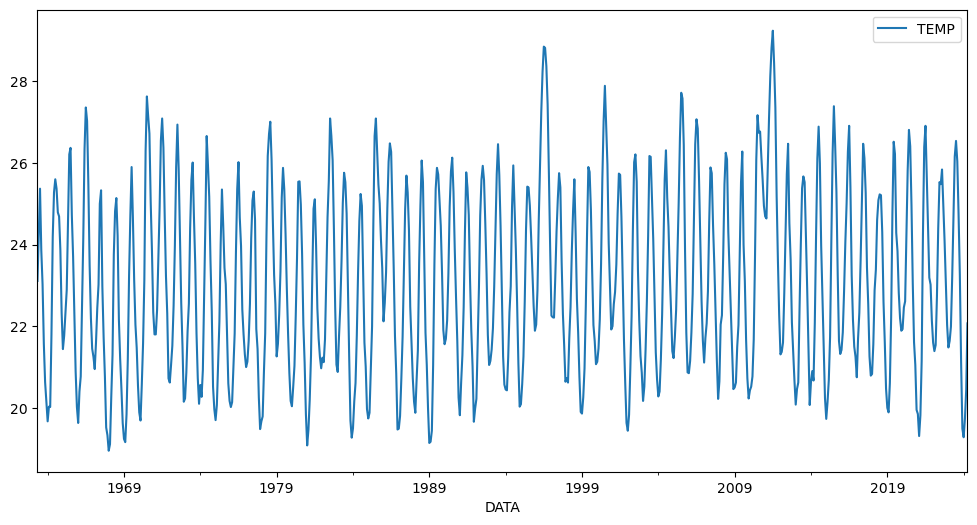

In [5]:
df_f1.plot(figsize=(12,6))
plt.show()

## Modelo ingênuo

Um modelo ingênuo (naive) em séries temporais é um dos métodos de previsão mais simples, baseando-se na suposição de que o melhor preditor para qualquer ponto futuro é o valor mais recente disponível na série. Isso significa que a previsão para todos os pontos futuros será igual ao último valor observado.

In [6]:
df_f1.shift(1)

,TEMP
DATA,
1963-05-01,NaN
1963-06-01,23.11
1963-07-01,24.20
1963-08-01,25.37
1963-09-01,23.86
...,...
2023-12-01,21.11
2024-01-01,19.49
2024-02-01,19.28


## Avaliando a estacionariedade

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

def estac(df):

    adf = adfuller(df)
    print(f'Valor-p do Teste ADF: {adf[1]:.4f}')
    if adf[1] > 0.05:
        print('Não rejeitar a Hipótese Nula: a série não é estacionária\n')
    else:
        print('Rejeitar a Hipótese Nula: a série é estacionária\n')
    
    kpss_saida = kpss(df)
    print(f'Valor-p do Teste KPSS: {kpss_saida[1]:.4f}')
    if kpss_saida[1] > 0.05:
        print('Não rejeitar a Hipótese Nula: a série é estacionária\n')
    else:
        print('Rejeitar a Hipótese Nula: a série não é estacionária\n')

In [8]:
estac(df_f1)

Valor-p do Teste ADF: 0.0000
Rejeitar a Hipótese Nula: a série é estacionária

Valor-p do Teste KPSS: 0.0798
Não rejeitar a Hipótese Nula: a série é estacionária



In [9]:
divisao = int(len(df_f1) * 0.7)

treino = df_f1.iloc[:divisao].asfreq('MS')
teste = df_f1.iloc[divisao:].asfreq('MS')

## Modelo Autoregressivo (AR)

Um modelo Autorregressivo (AR) é um tipo de modelo de previsão para séries temporais que utiliza uma combinação linear de valores passados da própria série para fazer previsões futuras. Ele se baseia na ideia de que observações passadas podem ser usadas para prever observações futuras de maneira estatisticamente significativa, especialmente quando a série exibe correlação ao longo do tempo.

A equação básica de um modelo autorregressivo de ordem $(p)$ (lag de $p$ períodos) é dada por:

$X_t = c + \beta_1 X_{t-1} + \beta_2 X_{t-2} + \dots + \beta_p X_{t-p} + \epsilon_t$

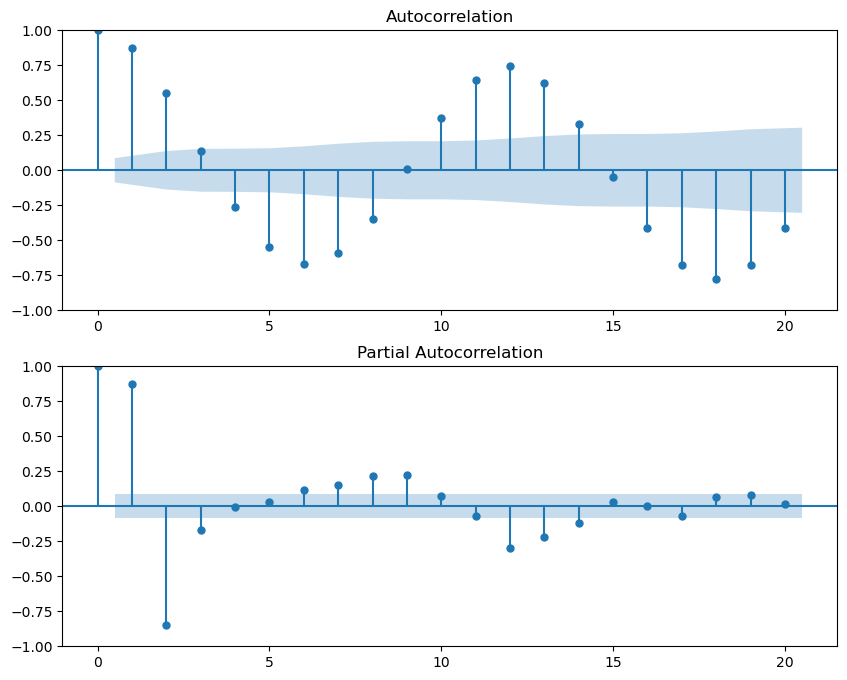

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

In [11]:
from statsmodels.tsa.ar_model import AutoReg

ar_mod = AutoReg(treino, 14, old_names=False)
ar_res = ar_mod.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Thu, 19 Jun 2025   AIC                            666.981
Time:                        08:23:46   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
TEMP.L1        1.1971      0.044     27.078      0.000       1.110       1.284
TEMP.L2       -0.3092      0.069     -4.470      0.0

d:\Users\akira\anaconda3\envs\lastversion\Lib\site-packages\statsmodels\tsa\ar_model.py:1138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_params[lag] = -params[i]


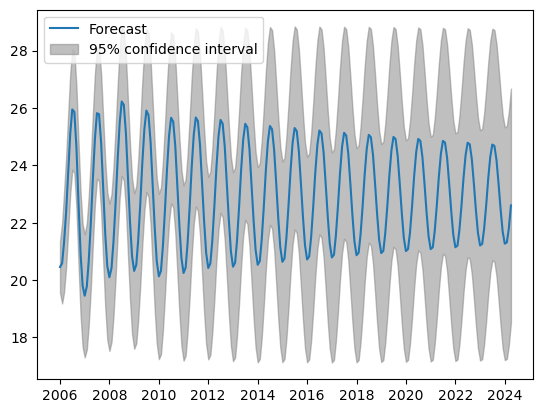

In [12]:
from statsmodels.tsa.ar_model import AutoRegResults

mod_result = AutoRegResults(ar_mod, ar_res.params, ar_res.cov_params())

fig = mod_result.plot_predict(len(treino), len(treino) + len(teste) - 1)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_prev(treino, teste, mod, nome_mod = ''):

  previsoes = mod.predict(len(treino), len(treino) + len(teste)-1, dynamic=False)

  plt.figure(figsize=(12, 5))

  plt.plot(teste.index, teste, label='Esperado')
  plt.plot(previsoes.index, previsoes, label='Previsto', color='red')

  plt.title(f'Previsão modelo {nome_mod}')
  plt.ylabel('Temperatura')
  plt.legend()
  plt.show()

  print('\nMétricas:\n')
  mae = mean_absolute_error(teste, previsoes)
  print(f'MAE: {mae}')

  mse = mean_squared_error(teste, previsoes)
  print(f'MSE: {mse}')

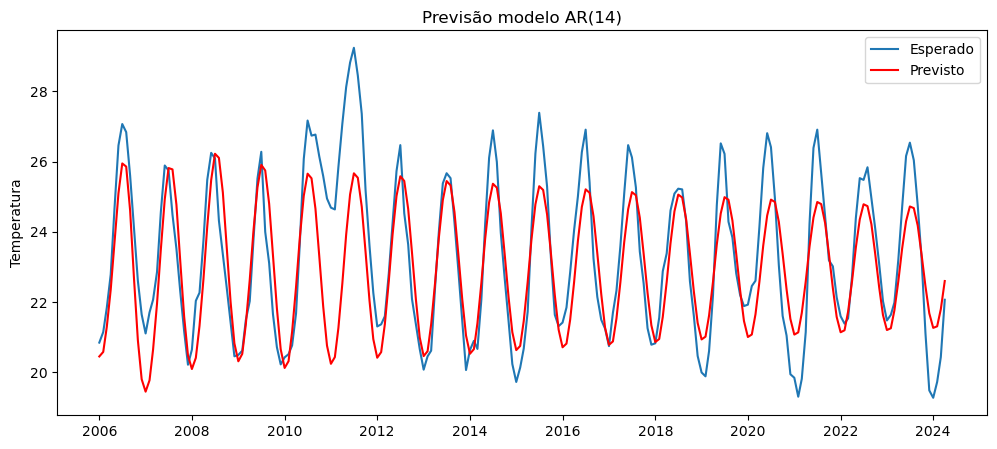


Métricas:

MAE: 1.042706398397293
MSE: 1.8489038142165852


In [14]:
plot_prev(treino, teste, ar_res, 'AR(14)')

### Busca de parâmetros

In [15]:
from statsmodels.tsa.ar_model import ar_select_order

ar_selecao = ar_select_order(treino, maxlag=35, old_names=False, ic='aic')

In [16]:
ar_selecao.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [17]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Thu, 19 Jun 2025   AIC                            603.684
Time:                        08:23:48   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
TEMP.L1        1.1355      0.045     25.067      0.000       1.047       1.224
TEMP.L2       -0.2017      0.068     -2.958      0.0

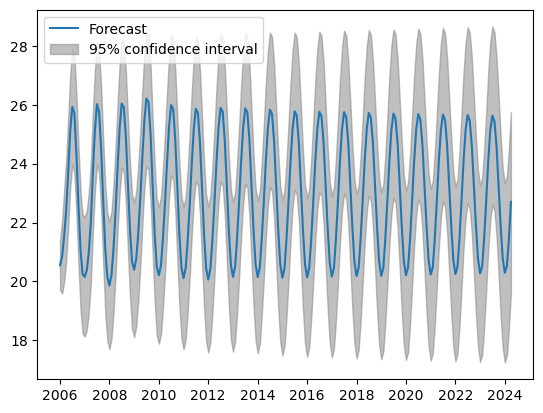

In [18]:
fig = ar_sel_res.plot_predict(len(treino), len(treino) + len(teste) - 1)

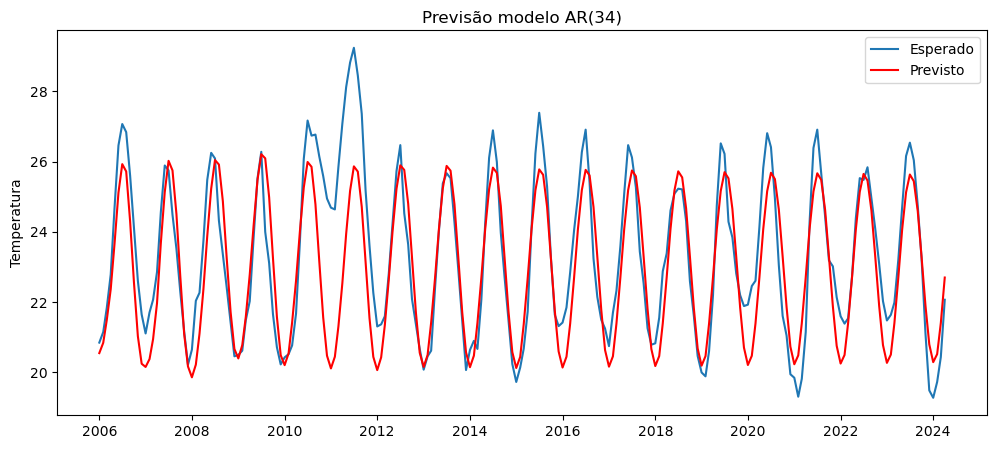


Métricas:

MAE: 0.9474776896239121
MSE: 1.6610673113323537


In [19]:
plot_prev(treino, teste, ar_sel_res, 'AR(34)')

# Fazenda 2

![Alt text: Imagem de uma fazenda com plantações de tomates](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%202.png?raw=true)

In [20]:
df_f2 = pd.read_csv(dados_f2)
df_f2

,DATA,TEMP
0,1966-02-01,23.436171
1,1966-03-01,29.787675
2,1966-04-01,25.626345
3,1966-05-01,22.958315
4,1966-06-01,19.513770
...,...,...
694,2023-12-01,15.033869
695,2024-01-01,17.323596
696,2024-02-01,22.818941
697,2024-03-01,29.429283


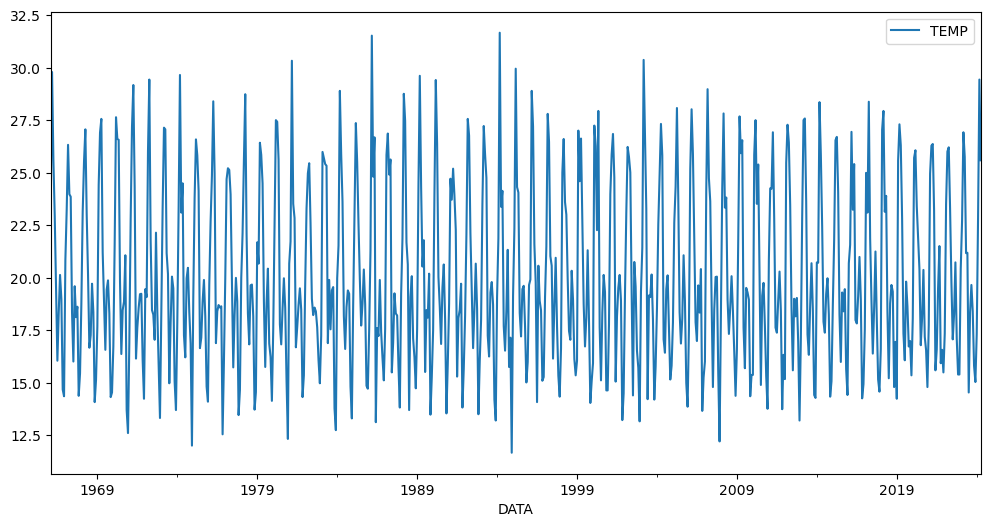

In [21]:
df_f2['DATA'] = pd.to_datetime(df_f2['DATA'], format='%Y-%m-%d')
df_f2.set_index(['DATA'], inplace=True, drop=True)
fig = df_f2.plot(figsize=(12, 6))

In [22]:
estac(df_f2)

Valor-p do Teste ADF: 0.0000
Rejeitar a Hipótese Nula: a série é estacionária

Valor-p do Teste KPSS: 0.1000
Não rejeitar a Hipótese Nula: a série é estacionária



C:\Users\akira\AppData\Local\Temp\ipykernel_21660\2978233726.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_saida = kpss(df)


In [23]:
divisao = int(len(df_f2) * 0.8)

treino = df_f2.iloc[:divisao].asfreq('MS')
teste = df_f2.iloc[divisao:].asfreq('MS')

## Construindo um modelo previsivo

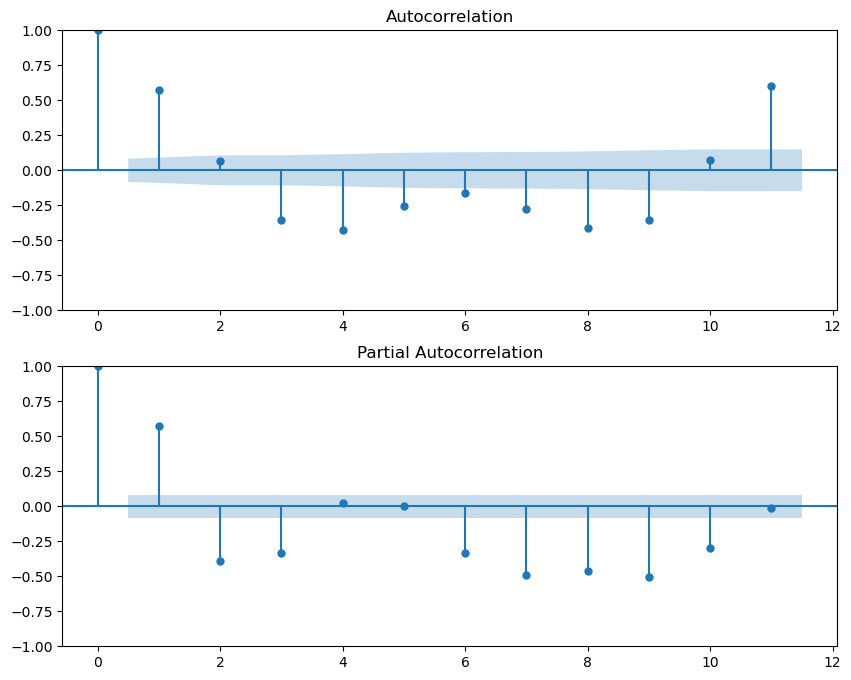

In [24]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=11, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=11, ax=ax2)

In [25]:
ar_mod_f2 = AutoReg(treino, 10, old_names=False).fit()
print(ar_mod_f2.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                    AutoReg(10)   Log Likelihood                -993.284
Method:               Conditional MLE   S.D. of innovations              1.477
Date:                Thu, 19 Jun 2025   AIC                           2010.569
Time:                        08:23:51   BIC                           2062.266
Sample:                    12-01-1966   HQIC                          2030.773
                         - 08-01-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.9748      3.244     34.518      0.000     105.617     118.333
TEMP.L1       -0.3349      0.037     -9.170      0.000      -0.406      -0.263
TEMP.L2       -0.3242      0.030    -10.926      0.0

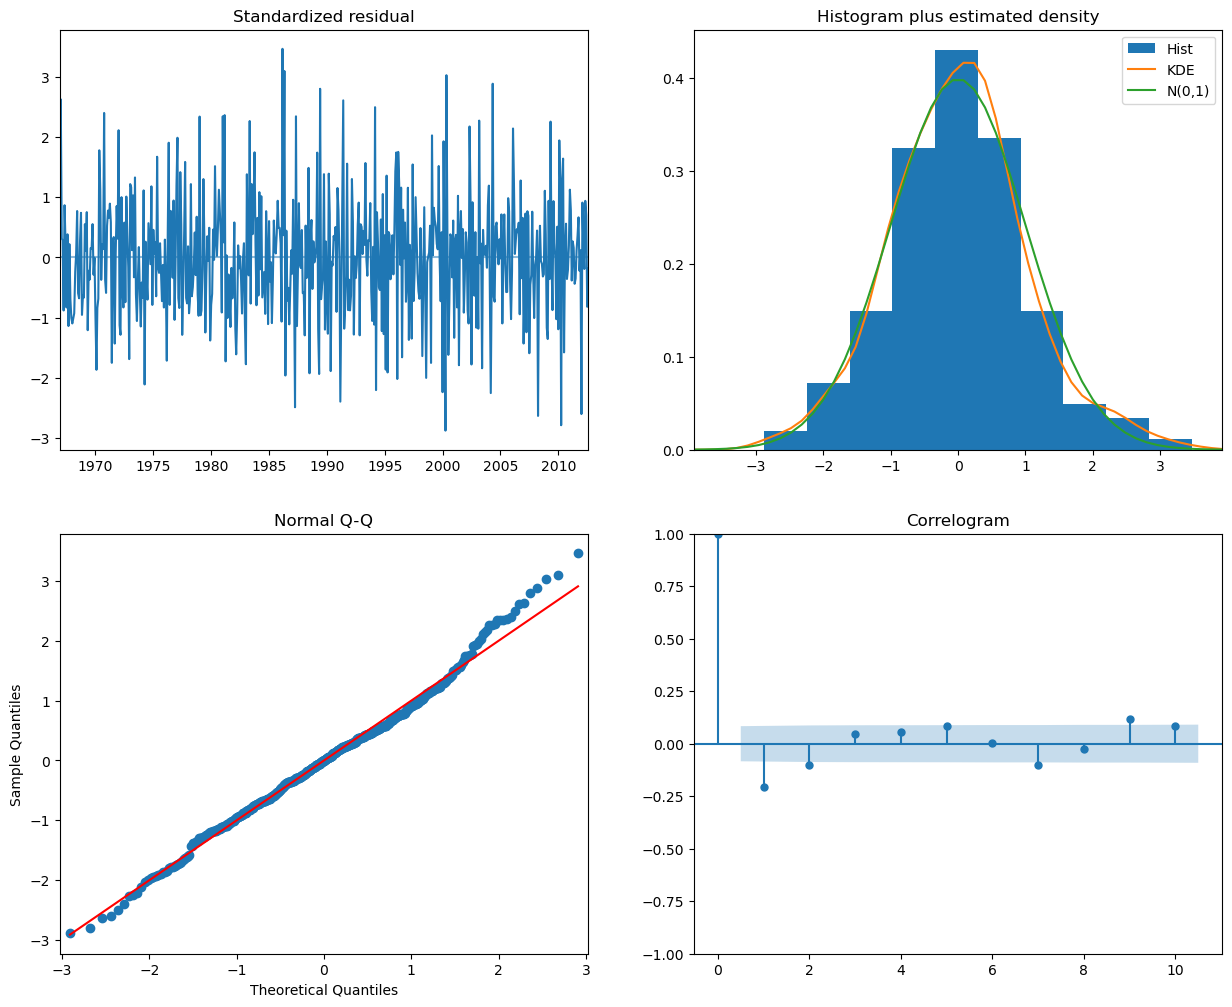

In [26]:
ar_mod_f2.plot_diagnostics(figsize=(15,12))
plt.show()

### Modelo Autorregressivo de Médias Móveis (ARMA)

O modelo ARMA é uma ferramenta estatística avançada usada na análise de séries temporais que combina duas características principais: autoregressiva (AR) e média móvel (MA).

O modelo ARMA é expresso pela seguinte equação:

$X_t = c + \epsilon_t + \sum_{i=1}^p \beta_i X_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j}$

In [27]:
from statsmodels.tsa.arima.model import ARIMA # ARIMA(p, d, q)

arma_mod = ARIMA(treino, order=(10, 0, 1)).fit()
print(arma_mod.summary())

d:\Users\akira\anaconda3\envs\lastversion\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Users\akira\anaconda3\envs\lastversion\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(10, 0, 1)   Log Likelihood                -988.510
Date:                Thu, 19 Jun 2025   AIC                           2003.020
Time:                        08:23:56   BIC                           2059.260
Sample:                    02-01-1966   HQIC                          2024.982
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9727      0.008   2365.302      0.000      19.956      19.989
ar.L1         -0.0891      0.058     -1.543      0.123      -0.202       0.024
ar.L2         -0.3211      0.034     -9.505      0.0

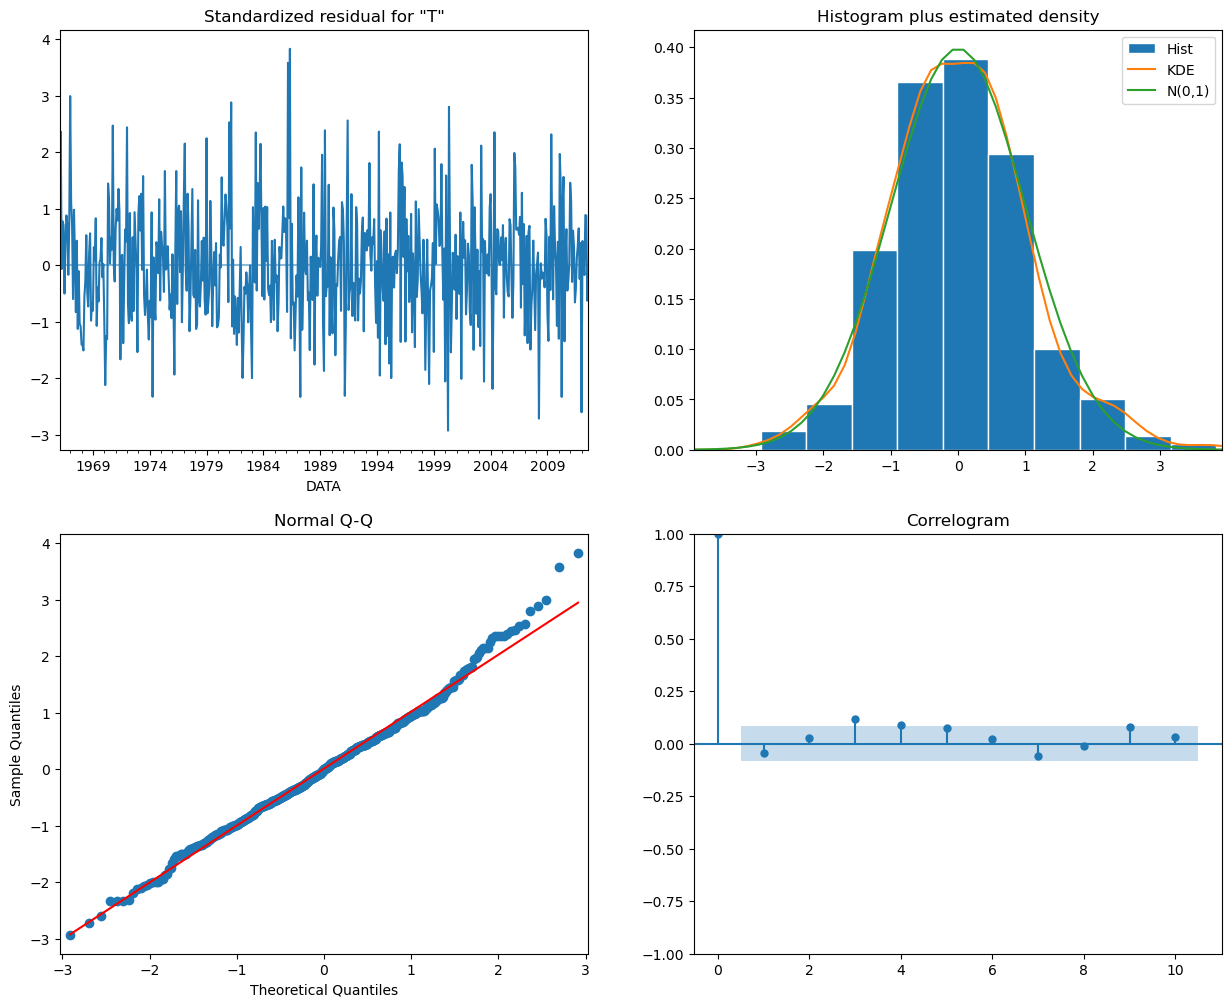

In [28]:
arma_mod.plot_diagnostics(figsize=(15, 12))
plt.show()

### Busca de parâmetros

In [29]:
import itertools
import warnings
warnings.filterwarnings("ignore")


def grid_arima(p_inicial, p_final, q_inicial, q_final, d_valores, treino):
  # Definindo os parâmetros
  p_params = range(p_inicial, p_final)
  q_params = range(q_inicial, q_final)
  d_params = [d_valores]

  # Gerando todas as combinações possíveis usando product
  combinacoes = list(itertools.product(p_params, d_params, q_params))

  aic_grid = dict()
  # Treinando o modelo e salvando todas combinações
  for order in combinacoes:
    try:
      model = ARIMA(treino, order = order).fit()
      aic_grid[order] = list()
      aic_grid[order].append((model.aic if model.aic else float('inf')))
    except:
      continue
  return aic_grid, min(aic_grid, key=lambda x: aic_grid[x][0])

In [30]:
aic_arma = grid_arima(10, 25, 1, 3, 0, treino)

In [31]:
aic_arma[0]

{(10, 0, 1): [np.float64(2003.020210478514)],
 (10, 0, 2): [np.float64(1997.2611390202946)],
 (11, 0, 1): [np.float64(1965.567915472476)],
 (11, 0, 2): [np.float64(1968.1620715178228)],
 (12, 0, 1): [np.float64(1966.8057159194932)],
 (12, 0, 2): [np.float64(1984.7811047090554)],
 (13, 0, 1): [np.float64(1966.830873367074)],
 (13, 0, 2): [np.float64(1973.0367422178997)],
 (14, 0, 1): [np.float64(1968.046873080239)],
 (14, 0, 2): [np.float64(1970.5191336658845)],
 (15, 0, 1): [np.float64(2014.5757174652165)],
 (15, 0, 2): [np.float64(1973.6451267602913)],
 (16, 0, 1): [np.float64(2023.2529634239388)],
 (16, 0, 2): [np.float64(1970.0210133820847)],
 (17, 0, 1): [np.float64(2024.4459935062118)],
 (17, 0, 2): [np.float64(1959.9641017975423)],
 (18, 0, 1): [np.float64(2021.0046479618354)],
 (18, 0, 2): [np.float64(1961.3193278686347)],
 (19, 0, 1): [np.float64(2012.8730454849124)],
 (19, 0, 2): [np.float64(1962.1583453751405)],
 (20, 0, 1): [np.float64(1970.1415655322478)],
 (20, 0, 2): [np.

In [32]:
aic_arma[1]

(24, 0, 2)

In [33]:
arma_mod_ot = ARIMA(treino, order=aic_arma[1]).fit()
print(arma_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(24, 0, 2)   Log Likelihood                -934.108
Date:                Thu, 19 Jun 2025   AIC                           1924.216
Time:                        08:32:21   BIC                           2045.348
Sample:                    02-01-1966   HQIC                          1971.519
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9728      0.004   4633.812      0.000      19.964      19.981
ar.L1         -0.4116      0.318     -1.296      0.195      -1.034       0.211
ar.L2          0.1878      0.130      1.445      0.1

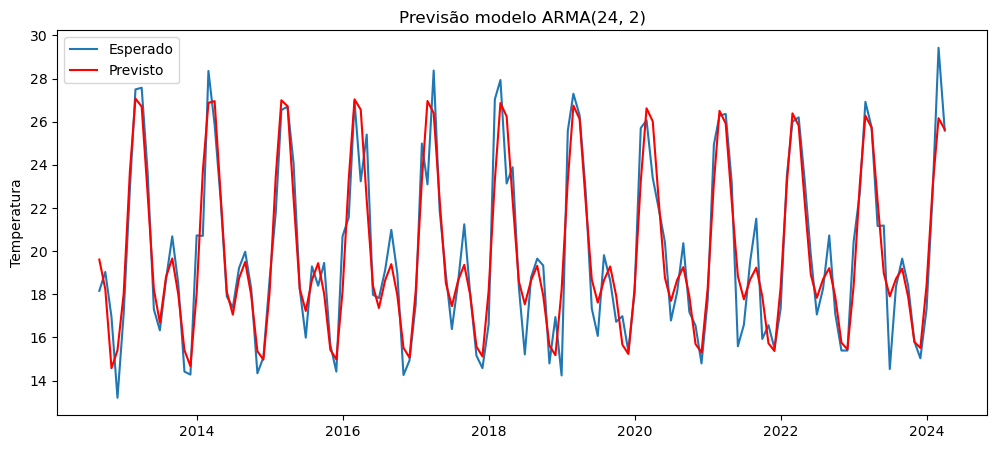


Métricas:

MAE: 1.0653809942447996
MSE: 1.979995950838641


In [34]:
plot_prev(treino, teste, arma_mod_ot, 'ARMA(24, 2)')

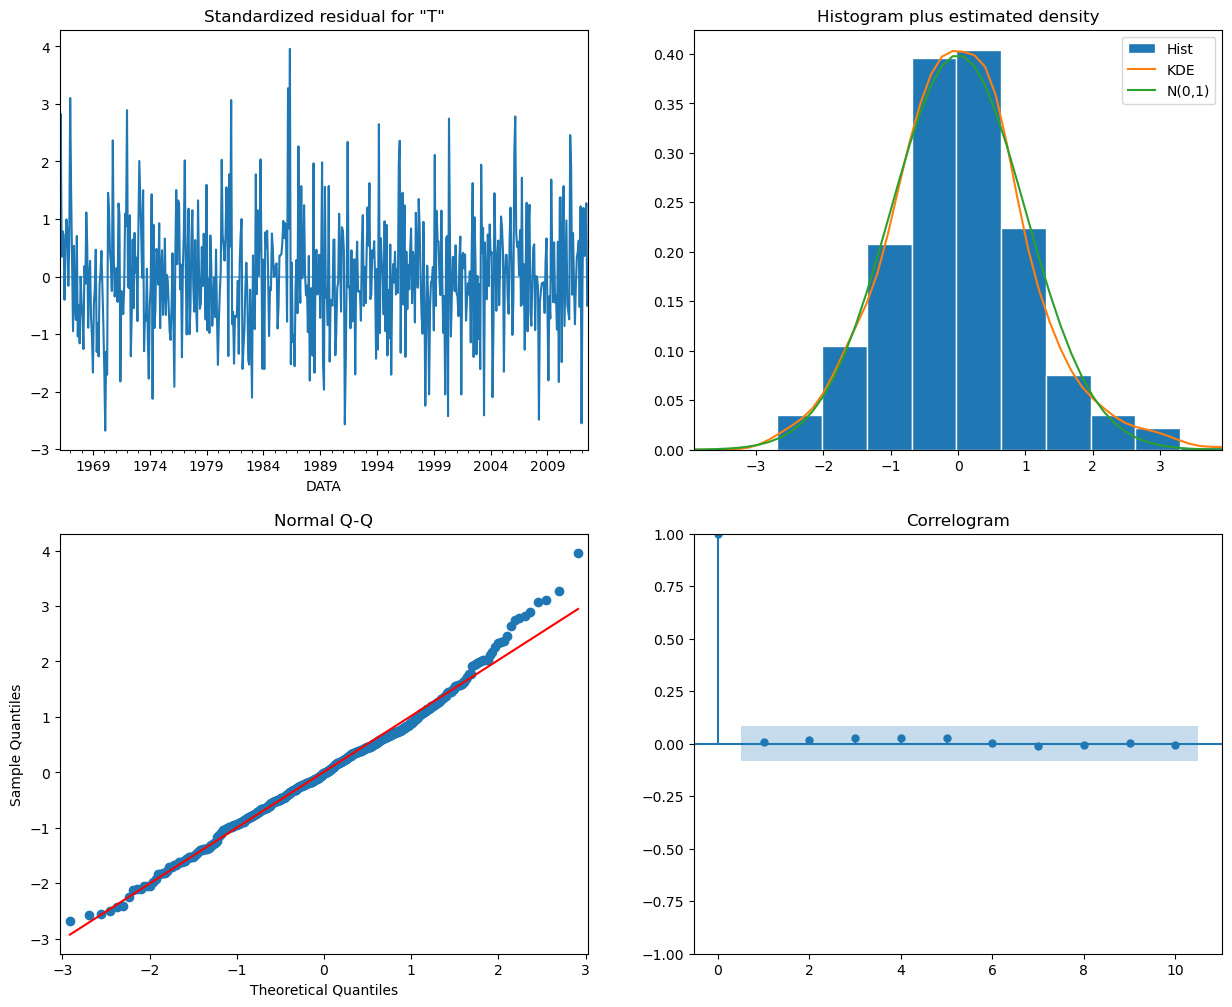

In [35]:
arma_mod_ot.plot_diagnostics(figsize=(15,12))
plt.show()

# Fazenda 3

![Alt text: Imagem de uma fazenda com plantações de arroz](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%203.png?raw=true)

In [36]:
df_f3 = pd.read_csv(dados_f3)
df_f3

,DATA,TEMP
0,1965-09-01,33.30
1,1965-10-01,32.88
2,1965-11-01,30.28
3,1965-12-01,30.42
4,1966-01-01,30.39
...,...,...
699,2023-12-01,31.72
700,2024-01-01,32.22
701,2024-02-01,32.29
702,2024-03-01,29.60


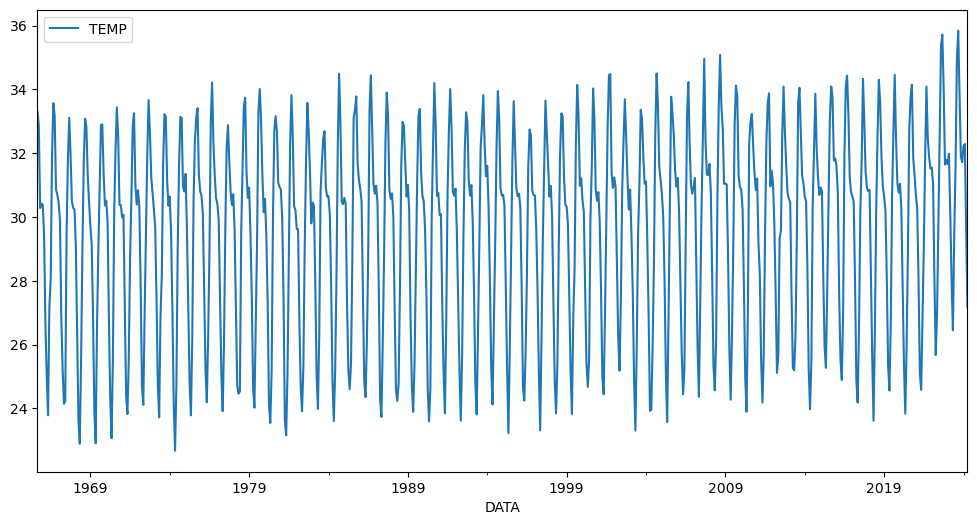

In [37]:
df_f3['DATA'] = pd.to_datetime(df_f3['DATA'], format='%Y-%m-%d')
df_f3.set_index(['DATA'], inplace=True, drop=True)
fig = df_f3.plot(figsize=(12, 6))

In [38]:
estac(df_f3)

Valor-p do Teste ADF: 0.0669
Não rejeitar a Hipótese Nula: a série não é estacionária

Valor-p do Teste KPSS: 0.0100
Rejeitar a Hipótese Nula: a série não é estacionária



In [39]:
df_f3.diff(1)

,TEMP
DATA,
1965-09-01,NaN
1965-10-01,-0.42
1965-11-01,-2.60
1965-12-01,0.14
1966-01-01,-0.03
...,...
2023-12-01,-0.16
2024-01-01,0.50
2024-02-01,0.07


In [40]:
estac(df_f3.diff(1).iloc[1:])

Valor-p do Teste ADF: 0.0000
Rejeitar a Hipótese Nula: a série é estacionária

Valor-p do Teste KPSS: 0.1000
Não rejeitar a Hipótese Nula: a série é estacionária



## Modelo Integrado Autorregressivo de Média Móveis (ARIMA)

In [41]:
divisao = int(len(df_f3) * 0.8)

treino = df_f3.iloc[:divisao].asfreq('MS')
teste = df_f3.iloc[divisao:].asfreq('MS')

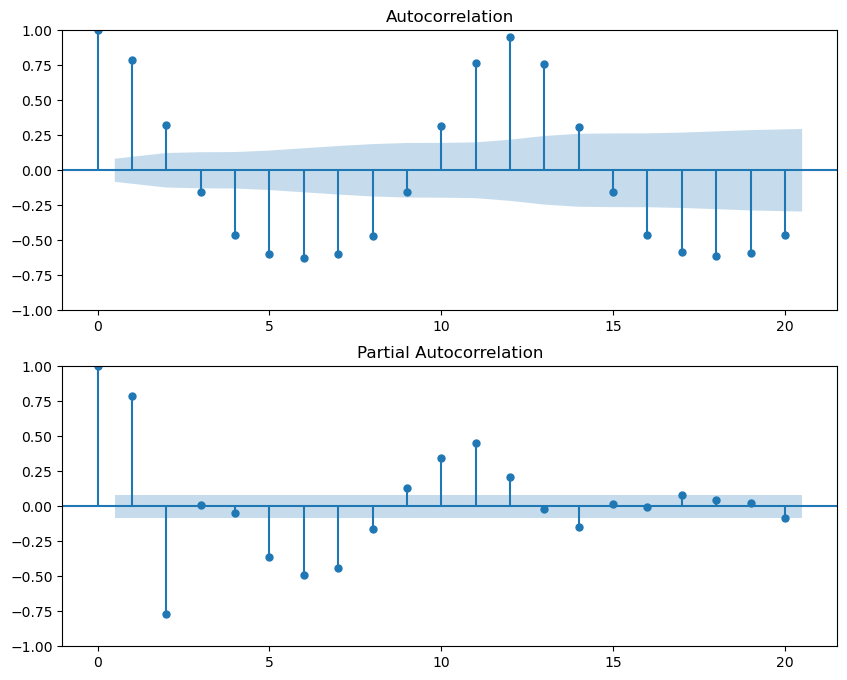

In [42]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

O modelo ARIMA combina três componentes principais: autorregressivo (AR), diferenciado (I de Integrated, ou integrado) e de média móvel (MA), o que o torna capaz de modelar uma ampla variedade de dados temporais.

O modelo ARIMA é geralmente representado como ARIMA(p, d, q), onde:

- $(p)$ é o número de termos autoregressivos,
- $( d )$ é o número de diferenciações necessárias para tornar a série temporal estacionária,
- $( q )$ é o número de termos de média móvel.

A equação genérica do modelo ARIMA é:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - L)^d X_t = (1 + \sum_{j=1}^q \theta_j L^j) \epsilon_t$

In [43]:
arima_mod = ARIMA(treino, order=(14, 1, 2)).fit()
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(14, 1, 2)   Log Likelihood                -544.655
Date:                Thu, 19 Jun 2025   AIC                           1123.309
Time:                        08:32:30   BIC                           1196.945
Sample:                    09-01-1965   HQIC                          1152.058
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4212      0.381     -1.105      0.269      -1.168       0.326
ar.L2          0.1403      0.417      0.336      0.737      -0.678       0.959
ar.L3         -0.2615      0.337     -0.775      0.4

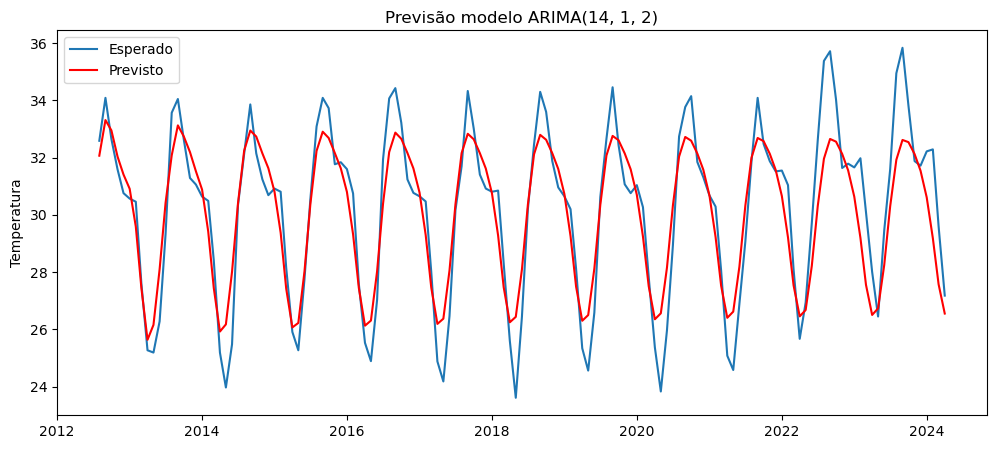


Métricas:

MAE: 1.0063032993839476
MSE: 1.6080909391933114


In [44]:
plot_prev(treino, teste, arima_mod, 'ARIMA(14, 1, 2)')

### Busca de parâmetros

In [45]:
aic_arima = grid_arima(14,25,1,3,1,treino)

In [46]:
aic_arima[1]

(24, 1, 2)

In [47]:
arima_mod_ot = ARIMA(treino, order = (24, 1, 2)).fit()
print(arima_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(24, 1, 2)   Log Likelihood                -504.897
Date:                Thu, 19 Jun 2025   AIC                           1063.795
Time:                        08:35:53   BIC                           1180.745
Sample:                    09-01-1965   HQIC                          1109.454
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4467      0.150     -2.969      0.003      -0.742      -0.152
ar.L2          0.1557      0.085      1.839      0.066      -0.010       0.322
ar.L3         -0.1439      0.070     -2.043      0.0

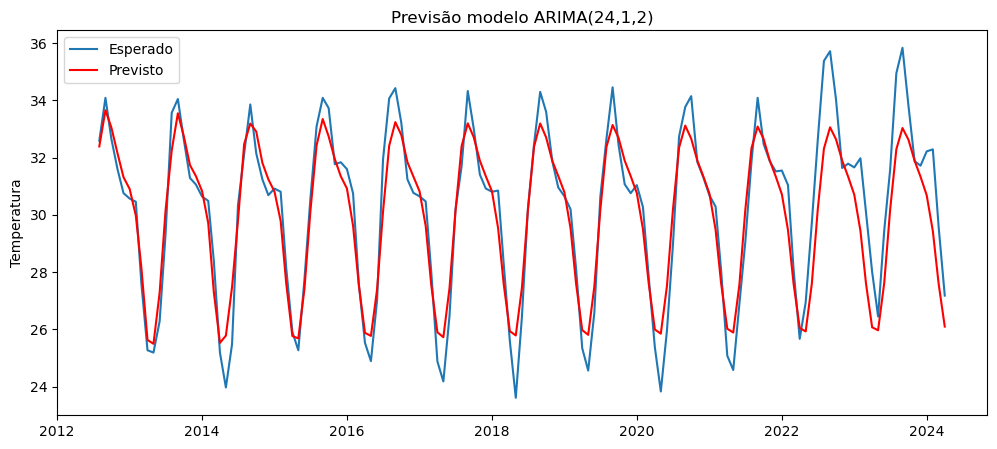


Métricas:

MAE: 0.8330235854675693
MSE: 1.162685766063196


In [48]:
plot_prev(treino, teste, arima_mod_ot, 'ARIMA(24,1,2)')

### **A sazonalidade**

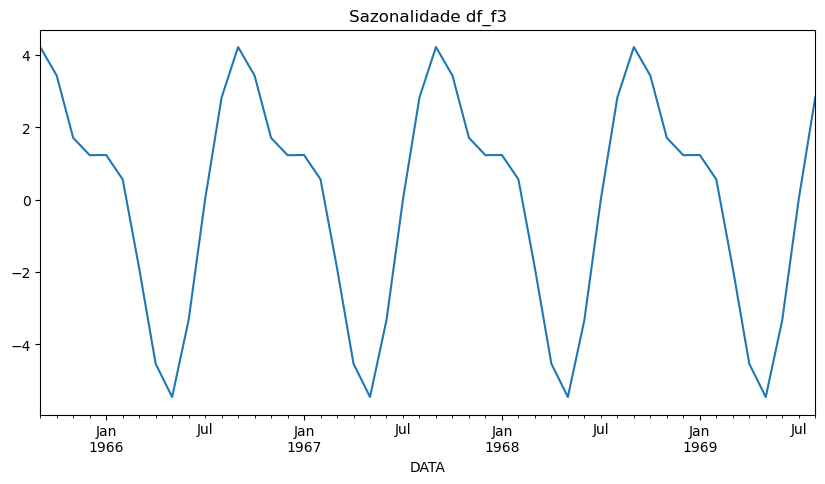

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao_df = seasonal_decompose(df_f3)

fig = plt.figure(figsize=(10,5))
decomposicao_df.seasonal.iloc[:48].plot(title='Sazonalidade df_f3')
plt.show()

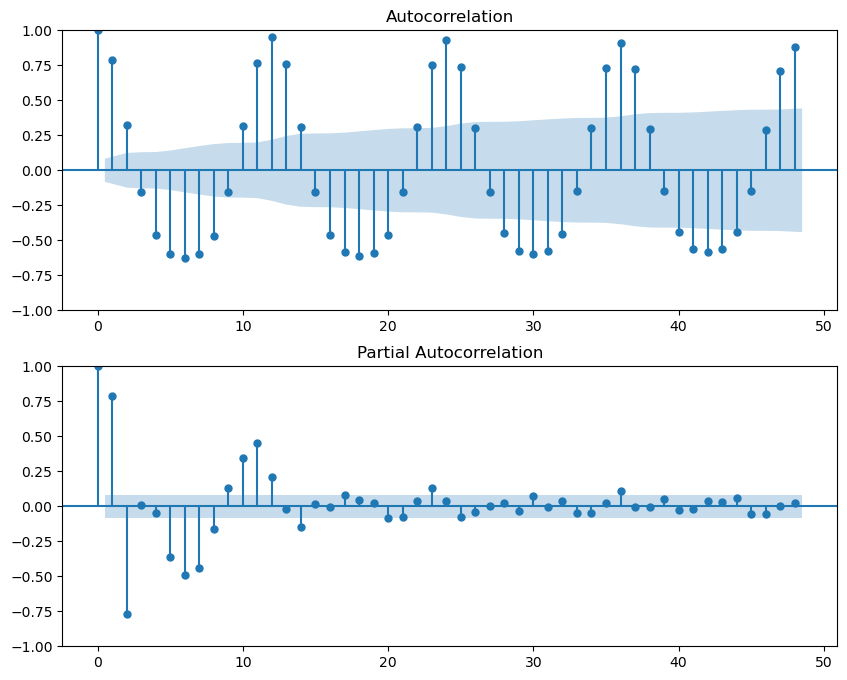

In [49]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=48, ax=ax2)

## Modelo Autorregressivo Sazonal de Média Móveis Integrado (SARIMA)

O modelo SARIMA é uma extensão do modelo ARIMA, projetado especificamente para modelar e prever séries temporais que exibem sazonalidade.

O modelo SARIMA pode ser descrito pela seguinte equação, que combina tanto os efeitos sazonais quanto os não sazonais:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - \sum_{i=1}^P B_i L^{is})(1 - L)^d(1 - L^s)^D X_t = (1 + \sum_{j=1}^q \theta_j L^j)(1 + \sum_{j=1}^Q \Theta_j L^{js}) \epsilon_t$

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_mod = SARIMAX(treino, order=(11, 1 , 2), seasonal_order=(2, 1, 1, 12)).fit()
print(sarima_mod.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  TEMP   No. Observations:                  563
Model:             SARIMAX(11, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -456.394
Date:                               Thu, 19 Jun 2025   AIC                            946.787
Time:                                       09:08:02   BIC                           1020.056
Sample:                                   09-01-1965   HQIC                           975.419
                                        - 07-01-2012                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5654      0.147     -3.835      0.000      -0.854      -0.276
ar.L2      

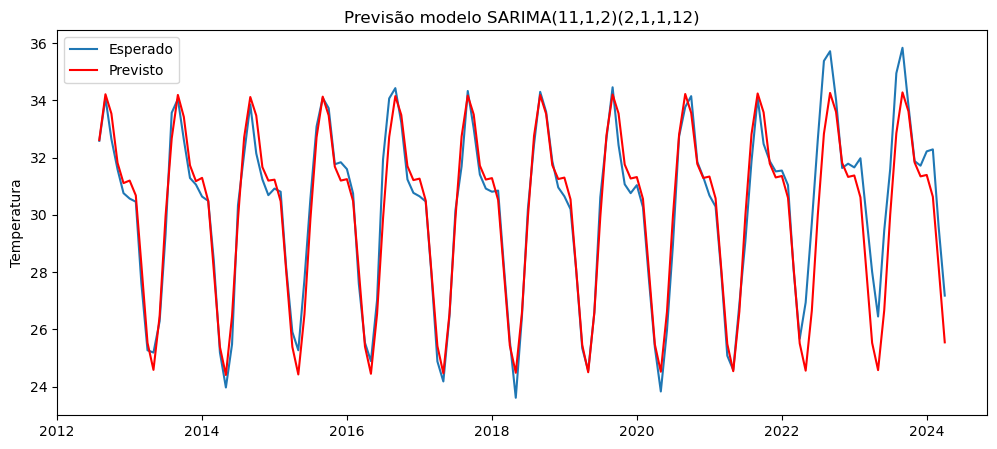


Métricas:

MAE: 0.5943477597288289
MSE: 0.7496668105422818


In [54]:
plot_prev(treino, teste, sarima_mod, 'SARIMA(11,1,2)(2,1,1,12)')

# Previsões das Fazendas

Temos 3 modelos para 3 conjuntos de dados sobre as temperaturas das fazendas

* Fazenda 1 modelo $AR(34)$
* Fazenda 2 modelo $ARMA(24,2)$
* Fazenda 3 modelo $SARIMA(11, 1, 1)\times (2, 1, 1, 12)$

```Python
mod_f1 = AutoReg(df_f1, 34, old_names=False).fit()
mod_f2 = ARIMA(df_f2, order=(24,0,2)).fit()
mod_f3 = SARIMAX(df_f3, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()
```

In [55]:
mod_f1 = AutoReg(df_f1, 34, old_names=False).fit()
mod_f2 = ARIMA(df_f2, order=(24,0,2)).fit()
mod_f3 = SARIMAX(df_f3, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()

In [56]:
previsao_f1 = mod_f1.predict(len(df_f1), len(df_f1)+35, dynamic=False)
previsao_f2 = mod_f2.predict(len(df_f2), len(df_f2)+35, dynamic=False)
previsao_f3 = mod_f3.predict(len(df_f3), len(df_f3)+35, dynamic=False)

In [57]:
previsao_f1

2024-05-01    23.754813
2024-06-01    25.073979
2024-07-01    25.745189
2024-08-01    25.482945
2024-09-01    24.688088
2024-10-01    23.396004
2024-11-01    21.987786
2024-12-01    20.884098
2025-01-01    20.462515
2025-02-01    20.671650
2025-03-01    21.437362
2025-04-01    22.747177
2025-05-01    24.272593
2025-06-01    25.631728
2025-07-01    26.151243
2025-08-01    25.772192
2025-09-01    24.810964
2025-10-01    23.402365
2025-11-01    21.817364
2025-12-01    20.637679
2026-01-01    20.235018
2026-02-01    20.583082
2026-03-01    21.474468
2026-04-01    22.864869
2026-05-01    24.469955
2026-06-01    25.757861
2026-07-01    26.256951
2026-08-01    25.993914
2026-09-01    25.070860
2026-10-01    23.642252
2026-11-01    22.077607
2026-12-01    20.899951
2027-01-01    20.356688
2027-02-01    20.564789
2027-03-01    21.397561
2027-04-01    22.680671
Freq: MS, dtype: float64

In [58]:
previsao_f2

2024-05-01    21.663400
2024-06-01    18.648024
2024-07-01    16.388394
2024-08-01    18.934714
2024-09-01    19.400349
2024-10-01    17.644566
2024-11-01    15.964506
2024-12-01    15.669455
2025-01-01    18.388834
2025-02-01    23.327774
2025-03-01    27.385344
2025-04-01    25.807880
2025-05-01    22.695489
2025-06-01    18.400564
2025-07-01    16.468903
2025-08-01    18.607779
2025-09-01    19.248706
2025-10-01    18.293949
2025-11-01    15.983242
2025-12-01    15.210835
2026-01-01    18.095872
2026-02-01    23.789531
2026-03-01    27.112358
2026-04-01    25.853165
2026-05-01    22.359416
2026-06-01    18.187705
2026-07-01    17.086451
2026-08-01    18.502056
2026-09-01    19.041283
2026-10-01    18.111885
2026-11-01    16.053566
2026-12-01    15.477865
2027-01-01    18.409603
2027-02-01    23.511670
2027-03-01    26.740361
2027-04-01    26.044679
Freq: MS, Name: predicted_mean, dtype: float64

In [59]:
previsao_f3

2024-05-01    26.206755
2024-06-01    27.991110
2024-07-01    31.328330
2024-08-01    33.903379
2024-09-01    35.305863
2024-10-01    34.591773
2024-11-01    32.902518
2024-12-01    32.366413
2025-01-01    32.534892
2025-02-01    31.849268
2025-03-01    29.481680
2025-04-01    26.804652
2025-05-01    26.024267
2025-06-01    28.060408
2025-07-01    31.441700
2025-08-01    34.127418
2025-09-01    35.489551
2025-10-01    34.752476
2025-11-01    33.007316
2025-12-01    32.558340
2026-01-01    32.566295
2026-02-01    31.920966
2026-03-01    29.551810
2026-04-01    26.924270
2026-05-01    25.994033
2026-06-01    28.160882
2026-07-01    31.445640
2026-08-01    34.256219
2026-09-01    35.618589
2026-10-01    34.766641
2026-11-01    33.019313
2026-12-01    32.585177
2027-01-01    32.618685
2027-02-01    32.006500
2027-03-01    29.567311
2027-04-01    26.945052
Freq: MS, Name: predicted_mean, dtype: float64